# Epidemiological SIR model

```{figure} ../videos/GalerkinProjection.mp4
    :width: 64%
    :align: left
    :figclass: margin-caption

Simulating an epidemic. YouTube, uploaded by 3Blue1Brown, April 2020, \href{https://www.youtube.com/watch?v=gxAaO2rsdIs&amp;t=185s}{https://www.youtube.com/watch?v=gxAaO2rsdIs&amp;t=185s}
```

In epidemiology, SIR (Susceptible, Infectious, Recovered) is a simplified set of equations to model how an infectious disease spreads through a population.


The form we consider here, the model consists of a system of four non-linear differential equations:
$$
\begin{align*}
\frac{\mathrm{d}S}{\mathrm{d}t} &= -\displaystyle \frac{\beta S}{N} I, \\
\frac{\mathrm{d}I}{\mathrm{d}t} &= \displaystyle \frac{\beta S}{N} I - \gamma I, \\
\frac{\mathrm{d}R}{\mathrm{d}t} &= \displaystyle \gamma I.
\end{align*}
$$

where $S(t)$, $I(t)$ and $R(t)$ are stochastic processes varying in time, and $N = S + I + R$ represents the population size.

The model has two model parameters: $\beta$ (transmission rate) and $\gamma$ (recovery rate), which determine how fast the disease spreads through the population and are different for every infectious disease, so they have to be estimated.


We can implement the relationship of these ordinary equations in terms of Python code:

In [7]:
def ode_sir(variables, coordinates, N, parameters):
    var_s, var_i, var_r = variables
    beta, gamma = parameters
    
    delta_s = -beta*var_i*var_s/N
    delta_i = beta*var_i*var_s/N -gamma*var_i
    delta_r = gamma*var_i
    
    return delta_s, delta_i, delta_r

## Initial condition

The initial condition is also random distributed, since it is almost impossible to have a precise number of Susceptible and Infected people at time 0. For this example, we will assume that all parameters are uniformly distributed with
$$
S(0) \sim \mathcal{U}(N\cdot0.64, N) \quad I(0)  \sim \mathcal{N}(10, 2)
$$

Or in terms of code:

In [8]:
import chaospy

def initial_condition(N):
    S = chaospy.Uniform(N*0.64, N)
    I = chaospy.Normal(10, 2)
    return S, I, N - S - I

## Model parameters

The model parameters $\beta$ and $\gamma$ are assumed to have a value, but are in all practical applications unknown. Because of this, it make more sense to assume that the parameters are inherently uncertain and can only be described through a probability distribution. For this example, we will assume that all parameters are uniformly distributed with
$$
\beta  \sim \mathcal{U}(0.95, 1.05) \quad \gamma  \sim \mathcal{U}(0.45, 0.55)
$$

Or using python code

In [9]:
import chaospy

beta = chaospy.Uniform(0.95, 1.05)
gamma = chaospy.Uniform(0.10, 0.15)
distribution = chaospy.J(beta, gamma)

## Deterministic model

To have a baseline of how this model works, we will first assume both the uncertain parameters and the initial conditions have some fixed value.

For example the expected value of the uncertain parameters:

In [10]:
parameters = chaospy.E(distribution)
print(parameters)

def det_initial_condition(N):
    s, i , r = initial_condition(N)
    distribution = chaospy.J(s, i)
    par = chaospy.E(distribution)
   
    r = N - par[0] - par[1]
    return par[0], par[1], r

print(det_initial_condition(1000))

[1.    0.125]
(820.0, 10.0, 170.0)


We then solve the SIR model on the time interval $[0, 60]$ using $1000$ steps using **scipy.integrate**:

In [11]:
import numpy as np
from scipy.integrate import odeint

N = 1000
time_span = np.linspace(0, 60, 1000)
responses = odeint(ode_sir, det_initial_condition(N), time_span, args=(N, parameters,))

We then use **matplotlib** to plot the four processes:

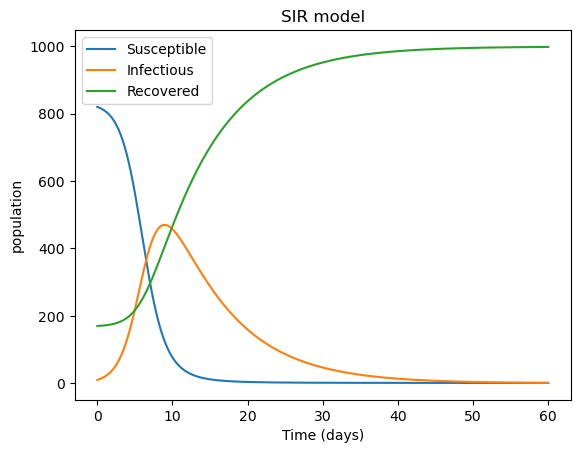

In [12]:
from matplotlib import pyplot

labels = ['Susceptible', 'Infectious', 'Recovered']
for response, label in zip(responses.T, labels):
    pyplot.plot(time_span, response, label=label)

pyplot.title('SIR model')
pyplot.xlabel('Time (days)')
pyplot.ylabel('population')
pyplot.legend()